In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [7]:
import requests
headers = {
    'user-agent': ('Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36'),  # noqa: E501
    'Dnt': ('1'),
    'Accept-Encoding': ('gzip, deflate, sdch'),
    'Accept-Language': ('en'),
    'origin': ('http://stats.nba.com')
    }


In [8]:
def load_nba_dataset(json_data):
    result_data = json_data['resultSets'][0]
    headers = result_data['headers']
    shots = result_data['rowSet']
    data_frame = pd.DataFrame(data=shots, columns=headers)
    return data_frame

In [9]:
curr_season = "http://stats.nba.com/stats/leaguedashplayerstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=2017-18&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&VsConference=&VsDivision=&Weight="
last_season = "http://stats.nba.com/stats/leaguedashplayerstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=2016-17&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&VsConference=&VsDivision=&Weight="

In [32]:
curr_season_stats = load_nba_dataset(requests.get(curr_season, headers=headers).json())
last_season_stats = load_nba_dataset(requests.get(last_season, headers=headers).json())

In [33]:
# Filtering minutes per game
curr_season_stats = curr_season_stats.loc[(curr_season_stats.MIN > 15) & (curr_season_stats.GP > 10)]

In [34]:
# Taking first 200 in 3 pointers attempted
curr_season_stats = curr_season_stats.loc[curr_season_stats.FG3A_RANK <= 100]

In [37]:
curr_season_stats.sort_values(by='FG3_PCT', ascending=False)

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,...,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,CFID,CFPARAMS
126,202734,E'Twaun Moore,1610612740,NOP,28.0,28,14,14,0.500,32.3,...,127,62,333,94,263,144,148,12,5,"202734,1610612740"
49,1627741,Buddy Hield,1610612758,SAC,23.0,25,9,16,0.360,23.1,...,58,216,316,106,372,145,148,12,5,"1627741,1610612758"
5,202329,Al-Farouq Aminu,1610612757,POR,27.0,13,4,9,0.308,29.4,...,273,204,263,158,36,128,90,12,5,"202329,1610612757"
263,202691,Klay Thompson,1610612744,GSW,27.0,28,22,6,0.786,33.4,...,165,211,182,22,11,49,90,12,5,"202691,1610612744"
212,204060,Joe Ingles,1610612762,UTA,30.0,27,13,14,0.481,29.8,...,151,146,191,137,312,124,148,12,5,"204060,1610612762"
84,203121,Darius Miller,1610612740,NOP,27.0,28,14,14,0.500,20.3,...,366,255,356,203,328,280,148,12,5,"203121,1610612740"
350,203490,Otto Porter Jr.,1610612764,WAS,24.0,26,14,12,0.538,32.5,...,145,172,204,65,91,51,26,12,5,"203490,1610612764"
269,2594,Kyle Korver,1610612739,CLE,36.0,28,20,8,0.714,22.5,...,289,240,248,138,12,215,148,12,5,"2594,1610612739"
445,203506,Victor Oladipo,1610612754,IND,25.0,26,16,10,0.615,34.0,...,5,81,33,10,52,13,90,12,5,"203506,1610612754"
419,202699,Tobias Harris,1610612765,DET,25.0,27,14,13,0.519,33.3,...,39,201,168,38,288,69,90,12,5,"202699,1610612765"


In [56]:
curr_season_stats.PLAYER_ID.tolist

Index([           u'PLAYER_ID',          u'PLAYER_NAME',
                    u'TEAM_ID',    u'TEAM_ABBREVIATION',
                        u'AGE',                   u'GP',
                          u'W',                    u'L',
                      u'W_PCT',                  u'MIN',
                        u'FGM',                  u'FGA',
                     u'FG_PCT',                 u'FG3M',
                       u'FG3A',              u'FG3_PCT',
                        u'FTM',                  u'FTA',
                     u'FT_PCT',                 u'OREB',
                       u'DREB',                  u'REB',
                        u'AST',                  u'TOV',
                        u'STL',                  u'BLK',
                       u'BLKA',                   u'PF',
                        u'PFD',                  u'PTS',
                 u'PLUS_MINUS',      u'NBA_FANTASY_PTS',
                        u'DD2',                  u'TD3',
                    u'GP_RANK',

In [93]:
def get_three_point_pct_diff(current_season, last_season):
    pct_diffs, attempts_diff = [], []
    last_years_pct, last_years_attempts = [], []
    for i in range(len(current_season)):
        curr_series = current_season.iloc[i]
        past_season_player = last_season.loc[last_season.PLAYER_ID == curr_series.PLAYER_ID]
        if curr_series.PLAYER_ID not in past_season_player.PLAYER_ID.tolist():
            pct_diffs.append(0.0)
            attempts_diff.append(0)
            last_years_pct.append(0)
            last_years_attempts.append(0)
            continue
        attempt_difference = curr_series.FG3A - past_season_player.FG3A.iloc[0]
        pct_diff = curr_series.FG3_PCT - past_season_player.FG3_PCT.iloc[0]
        last_years_pct.append(past_season_player.FG3_PCT.iloc[0])
        last_years_attempts.append(past_season_player.FG3A.iloc[0])
        pct_diffs.append(pct_diff)
        attempts_diff.append(attempt_difference)
    current_season['PCT_DIFF'] = pct_diffs
    current_season['ATT_DIFF'] = attempts_diff
    current_season['FG3_PCT_LAST'] = last_years_pct
    current_season['FG3_ATT_LAST'] = last_years_attempts
    return current_season

In [94]:
curr_season_stats = get_three_point_pct_diff(curr_season_stats, last_season_stats)

In [95]:
top_8_improved_shooters = curr_season_stats.sort_values(by="PCT_DIFF", ascending=False).iloc[:8]

In [96]:
top_8_improved_shooters = top_8_improved_shooters.sort_index()

In [134]:
top_8_improved_shooters

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,...,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,CFID,CFPARAMS,PCT_DIFF,ATT_DIFF,FG3_PCT_LAST,FG3_ATT_LAST
1,203932,Aaron Gordon,1610612753,ORL,22.0,25,10,15,0.400,33.7,...,345,33,32,12,5,"203932,1610612753",0.113,2.2,0.288,3.3
5,202329,Al-Farouq Aminu,1610612757,POR,27.0,13,4,9,0.308,29.4,...,36,128,90,12,5,"202329,1610612757",0.134,0.8,0.330,3.5
126,202734,E'Twaun Moore,1610612740,NOP,28.0,28,14,14,0.500,32.3,...,263,144,148,12,5,"202734,1610612740",0.103,1.2,0.370,2.8
253,1626162,Kelly Oubre Jr.,1610612764,WAS,22.0,27,14,13,0.519,27.4,...,207,138,148,12,5,"1626162,1610612764",0.087,1.6,0.287,2.4
375,203496,Robert Covington,1610612755,PHI,26.0,25,13,12,0.520,32.2,...,27,54,90,12,5,"203496,1610612755",0.094,1.6,0.333,6.1
408,1627752,Taurean Prince,1610612737,ATL,23.0,27,6,21,0.222,31.2,...,417,93,70,12,5,"1627752,1610612737",0.097,2.3,0.324,1.7
419,202699,Tobias Harris,1610612765,DET,25.0,27,14,13,0.519,33.3,...,288,69,90,12,5,"202699,1610612765",0.096,2.4,0.347,3.8
445,203506,Victor Oladipo,1610612754,IND,25.0,26,16,10,0.615,34.0,...,52,13,90,12,5,"203506,1610612754",0.083,0.9,0.361,5.3


In [257]:
plt.style.use('fivethirtyeight')

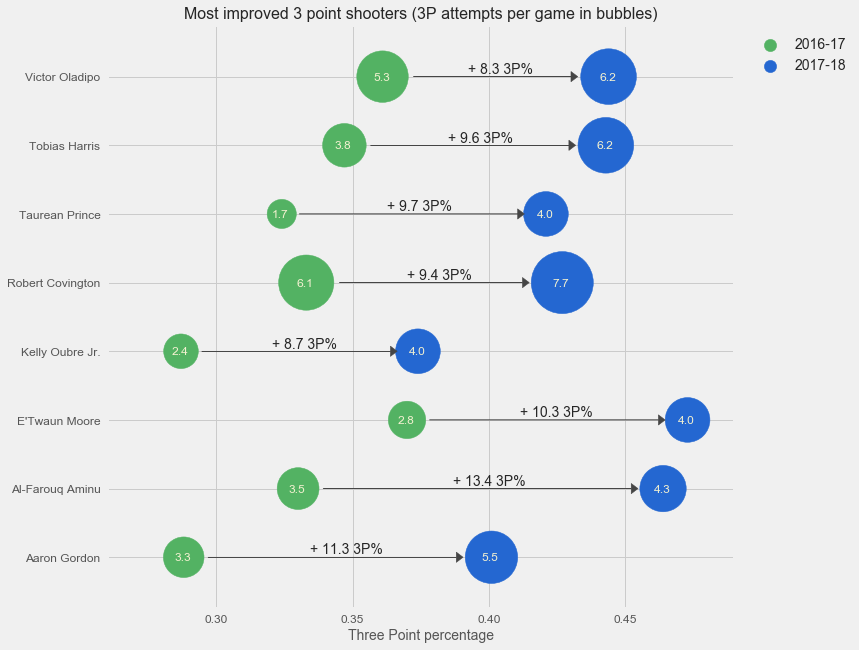

In [259]:
plt.figure(figsize=(10, 10))
dpi = plt.gcf().get_dpi()
plt.scatter(top_8_improved_shooters.FG3_PCT_LAST, top_8_improved_shooters.PLAYER_NAME, color="#53B263", s=500 * top_8_improved_shooters.FG3_ATT_LAST, label="2016-17")
plt.scatter(top_8_improved_shooters.FG3_PCT, top_8_improved_shooters.PLAYER_NAME, color="#2467D1", s=500 * top_8_improved_shooters.FG3A, label="2017-18")

# plt.hlines(top_8_improved_shooters.PLAYER_NAME, top_8_improved_shooters.FG3_PCT_LAST, top_8_improved_shooters.FG3_PCT, colors=["#415951"])

for i in range(len(top_8_improved_shooters)):
    current = top_8_improved_shooters.iloc[i]
    y = i # current index equals the string index
    plt.text(x=current.FG3_PCT_LAST - 0.0035, y= y-0.05, s=current.FG3_ATT_LAST, color="#F3F1D0", fontsize=12)
    plt.text(x=current.FG3_PCT - 0.0035, y= y-0.05, s=current.FG3A, color="#F3F1D0", fontsize=12)
    
    marker_size = current.FG3_ATT_LAST * 200
    marker_size = marker_size**(0.5) / 2.0
    marker_size /= dpi * 2 * 10 # dpi = 72, 72 * 2 = 144  ?? maybe
    
    target_marker_size = current.FG3A * 200
    target_marker_size = target_marker_size**(0.5) / 2.0
    target_marker_size /= dpi * 2 * 10

    start_x = current.FG3_PCT_LAST + marker_size
    dx = current.FG3_PCT - start_x - marker_size
    if current.PLAYER_NAME in ["Taurean Prince", "Aaron Gordon", "Tobias Harris"]:
        dx -= 0.0015 # heh, some hardcoding
    arrow = plt.arrow(x=start_x, y= y, dx=dx, dy=0, head_length=0.0025, head_width=0.15, length_includes_head=True, fc='#454545', color='#454545')
    
    plt.text(x=(current.FG3_PCT + current.FG3_PCT_LAST) / 2 - 0.01, y = y+0.05, s="+ " + str(current.PCT_DIFF*100) + " 3P%")
plt.title("Most improved 3 point shooters (3P attempts per game in bubbles)", fontsize=16)
plt.xlabel("Three Point percentage", fontsize=14)
plt.tick_params(axis='both', labelsize=12)

plt.xlim(0.26, 0.49)
legend = plt.legend(fontsize=14, bbox_to_anchor=(1.2,1))
legend.legendHandles[0]._sizes = [150]
legend.legendHandles[1]._sizes = [150]
plt.savefig('3p_shooting_change.png', bbox_inches='tight')